# Load of Data 

In [12]:
import pandas as pd
import os
import re

# Input files
files = [
    "./input_datasets/eleicoes/AR_2011_Globais.xls",
    "./input_datasets/eleicoes/AR_2015_Globais.xls",
    "./input_datasets/eleicoes/AR_2019_Globais.xlsx",
    "./input_datasets/eleicoes/AR_2022_Globais.xlsx",
    "./input_datasets/eleicoes/AR_2024_Globais.xlsx"
]

# Output config
output_dir = "./datasets/eleicoes"
output_filename = "legislativas.xlsx"
output_path = os.path.join(output_dir, output_filename)

def clean_party_name(name):
    return str(name).replace(".", "_").strip()

def process_election_files(file_paths):
    final_df = []

    for file_path in file_paths:
        year_match = re.search(r'AR_(\d{4})_Globais', os.path.basename(file_path))
        if not year_match:
            continue
        year = int(year_match.group(1))

        engine = "xlrd" if file_path.endswith(".xls") else "openpyxl"
        xls = pd.ExcelFile(file_path, engine=engine)

        concelho_sheet = f"AR_{year}_Concelho"
        freguesia_sheet = f"AR_{year}_Freguesia"

        # Load Concelho Data
        df_concelho = pd.read_excel(xls, sheet_name=concelho_sheet, skiprows=4, usecols=[0, 1])
        df_concelho.columns = ['concelho_code', 'concelho_name']

        # Filter out non-numeric or footer rows
        df_concelho = df_concelho[df_concelho['concelho_code'].apply(lambda x: str(x).isdigit())]
        df_concelho['concelho_code'] = df_concelho['concelho_code'].astype(int)
        df_concelho = df_concelho[df_concelho['concelho_code'] != 500000]
        df_concelho['concelho_code'] = df_concelho['concelho_code'].astype(str).str.zfill(6)

        concelho_map = df_concelho.set_index('concelho_code')['concelho_name'].to_dict()

        # Load Freguesia Data
        df_freguesia = pd.read_excel(xls, sheet_name=freguesia_sheet, skiprows=4, header=None)
        header_row = pd.read_excel(xls, sheet_name=freguesia_sheet, nrows=4, header=None)

        # Detect where party columns start
        header_line = header_row.iloc[3].astype(str).str.lower()
        if "total de concelhos" in header_line.values or "total de consulados" in header_line.values:
            base_end_index = 12
        else:
            base_end_index = 9

        max_cols = df_freguesia.shape[1]
        party_pairs = list(range(base_end_index + 1, max_cols, 2))

        for col_idx in party_pairs:
            if col_idx + 1 >= max_cols:
                continue

            party_name_raw = header_row.iloc[3, col_idx]
            if pd.isna(party_name_raw) or str(party_name_raw).strip() == "":
                continue

            party_name = clean_party_name(party_name_raw)

            df_tmp = df_freguesia.loc[:, [
                0,  # freguesia code
                1,  # freguesia name
                6, 7, 8,               # inscritos, votantes, votantes_percent
                9, 10,                 # brancos, brancos_percent
                11, 12,                # nulos, nulos_percent
                col_idx, col_idx + 1  # partido_votes, partido_percent
            ]].copy()

            df_tmp.columns = [
                'freguesia', 'freguesia_name',
                'inscritos', 'votantes', 'votantes_percent',
                'brancos', 'brancos_percent', 'nulos', 'nulos_percent',
                'partido_votes', 'partido_percent'
            ]

            # Clean codes
            df_tmp = df_tmp[df_tmp['freguesia'].notnull()]
            df_tmp['freguesia'] = pd.to_numeric(df_tmp['freguesia'], errors='coerce')
            df_tmp = df_tmp[df_tmp['freguesia'].notnull()]
            df_tmp['freguesia'] = df_tmp['freguesia'].astype(int).astype(str).str.zfill(6)

            # Derive concelho_code and map name
            df_tmp['concelho'] = df_tmp['freguesia'].str[:4] + "00"
            df_tmp['concelho_name'] = df_tmp['concelho'].map(concelho_map)

            df_tmp['year'] = year
            df_tmp['partido'] = party_name

            final_df.append(df_tmp)

    # Merge all and return final result
    result = pd.concat(final_df, ignore_index=True)
    result = result[[
        'year', 'concelho', 'concelho_name', 'freguesia', 'freguesia_name',
        'inscritos', 'votantes', 'votantes_percent',
        'brancos', 'brancos_percent', 'nulos', 'nulos_percent',
        'partido', 'partido_votes', 'partido_percent'
    ]]
    return result

# Run the pipeline
df_results = process_election_files(files)
os.makedirs(output_dir, exist_ok=True)
df_results.to_excel(output_path, index=False)


# Data Analysis

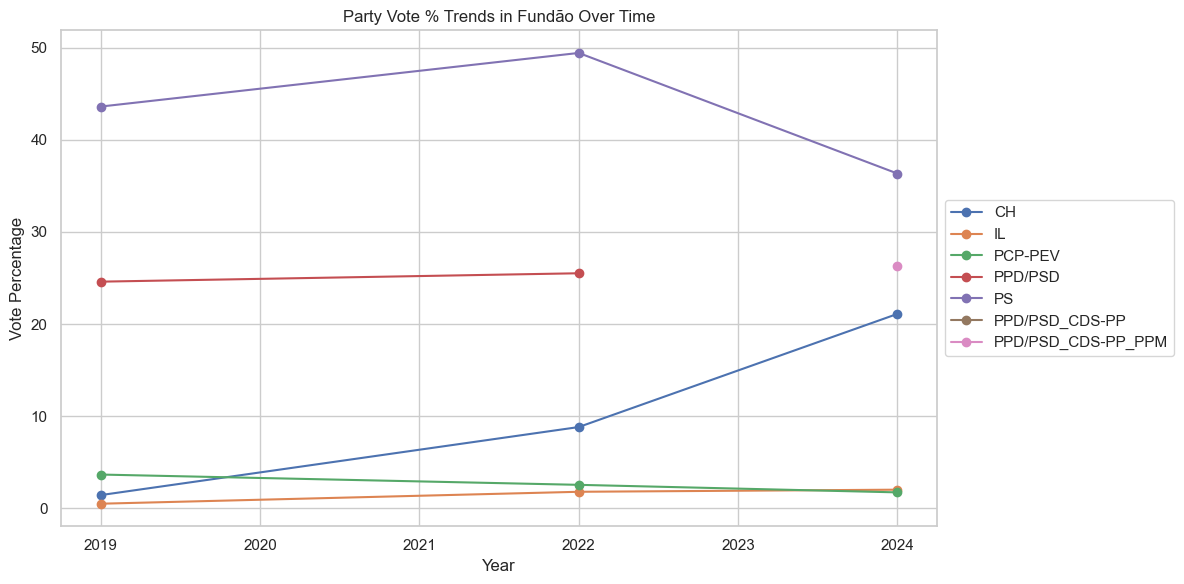

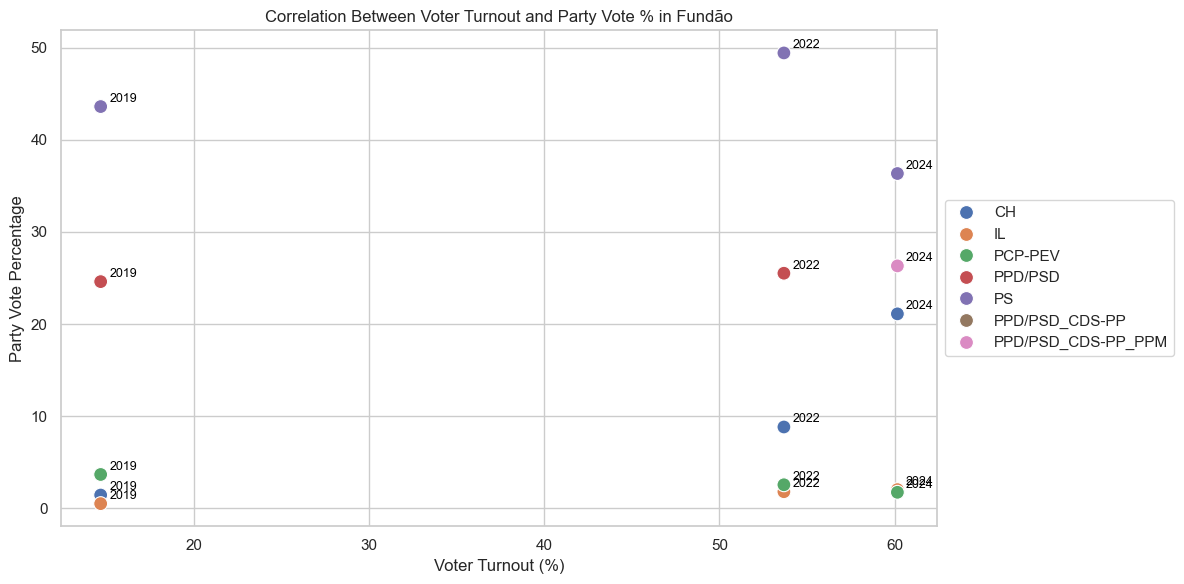

/var/folders/y7/46pmn6xd3rdg0pdjl839g_xm0000gn/T/ipykernel_28550/1776878166.py:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=vote_shift_sorted['growth'], y=vote_shift_sorted.index, palette="coolwarm")


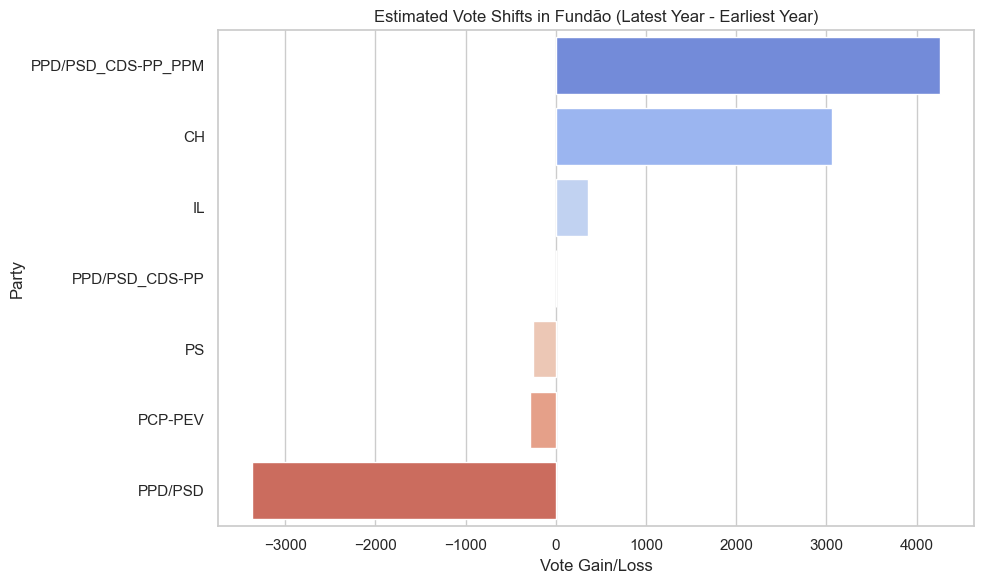

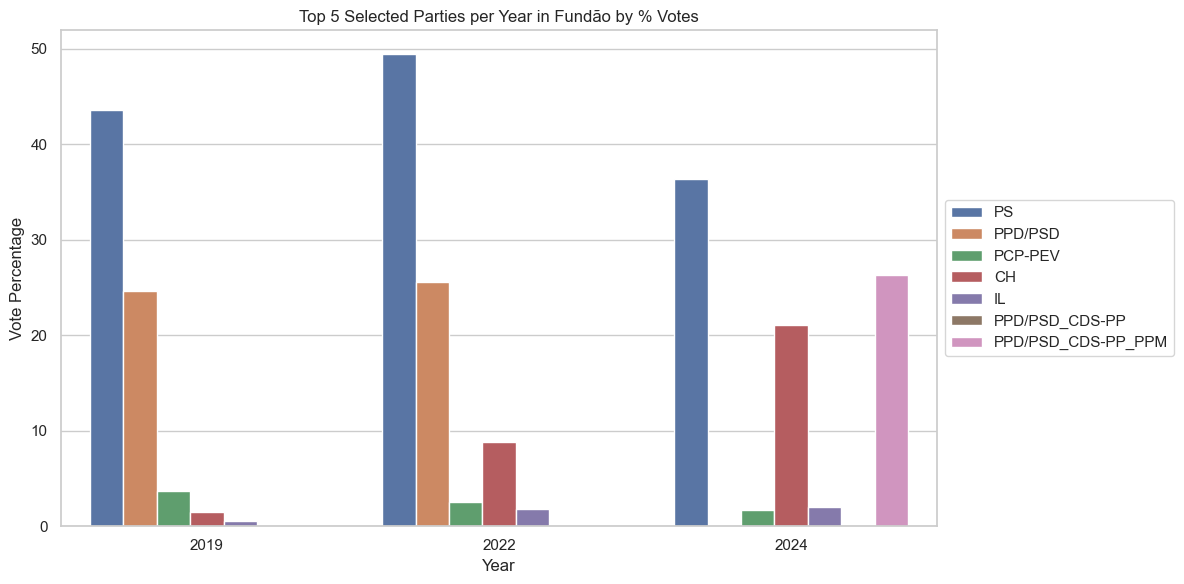

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_excel("./datasets/eleicoes/legislativas.xlsx")

# Step 0: Define your party keyword filters (case-insensitive partial match)
selected_keywords = ['PS', 'PSD', 'CDU', 'BE', 'CH', 'IL','PCP']  # Customize as needed
pattern = '|'.join(selected_keywords)

# Filter for Fundão and selected parties (partial match)
df_fundao = df[df['concelho_name'].str.lower() == 'fundão'.lower()].copy()
df_fundao['year'] = df_fundao['year'].astype(int)
df_fundao['partido_percent'] = pd.to_numeric(df_fundao['partido_percent'], errors='coerce')
df_fundao['partido_votes'] = pd.to_numeric(df_fundao['partido_votes'], errors='coerce')
df_fundao = df_fundao[df_fundao['partido'].str.contains(pattern, case=False, na=False)]

# Aggregate by year and party
df_party_trends = df_fundao.groupby(['year', 'partido']).agg({
    'partido_votes': 'sum',
    'partido_percent': 'mean',
    'votantes_percent': 'mean'
}).reset_index()

# Set plot style
sns.set(style="whitegrid")

# Step 1: Party Vote % Trends Over Time
plt.figure(figsize=(12, 6))
for partido in df_party_trends['partido'].unique():
    party_data = df_party_trends[df_party_trends['partido'] == partido]
    if not party_data.empty:
        plt.plot(party_data['year'], party_data['partido_percent'], marker='o', label=partido)
plt.title("Party Vote % Trends in Fundão Over Time")
plt.xlabel("Year")
plt.ylabel("Vote Percentage")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

# Step 2: Correlation Between Turnout and Party Vote % WITH YEAR LABELS
plt.figure(figsize=(12, 6))
ax = sns.scatterplot(
    data=df_party_trends,
    x="votantes_percent",
    y="partido_percent",
    hue="partido",
    s=100  # increase point size for clarity
)

# Annotate each point with the year
for i, row in df_party_trends.iterrows():
    turnout = float(row['votantes_percent'])
    percent = float(row['partido_percent'])
    year = str(row['year'])
    ax.annotate(year, (turnout + 0.5, percent + 0.5), fontsize=9, color='black')

plt.title("Correlation Between Voter Turnout and Party Vote % in Fundão")
plt.xlabel("Voter Turnout (%)")
plt.ylabel("Party Vote Percentage")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

# Step 3: Estimated Vote Shift (first to last year)
vote_shift = df_party_trends.pivot(index='partido', columns='year', values='partido_votes').fillna(0)
vote_shift['growth'] = vote_shift.iloc[:, -1] - vote_shift.iloc[:, 0]
vote_shift_sorted = vote_shift.sort_values(by='growth', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=vote_shift_sorted['growth'], y=vote_shift_sorted.index, palette="coolwarm")
plt.title("Estimated Vote Shifts in Fundão (Latest Year - Earliest Year)")
plt.xlabel("Vote Gain/Loss")
plt.ylabel("Party")
plt.tight_layout()
plt.show()

# Step 4: Top 5 Parties Per Year by Vote Percentage
top5_df = df_party_trends.sort_values(['year', 'partido_percent'], ascending=[True, False]) \
                         .groupby('year').head(7)

plt.figure(figsize=(12, 6))
sns.barplot(data=top5_df, x="year", y="partido_percent", hue="partido")
plt.title("Top 5 Selected Parties per Year in Fundão by % Votes")
plt.ylabel("Vote Percentage")
plt.xlabel("Year")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()
